<a name="lib"></a>

# Import libraries and packages

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# For retrieving data
import yfinance as yf

from datetime import datetime, timedelta

# Import Dataset

In [4]:
START = "2015-01-01"
TODAY = datetime.today().strftime("%Y-%m-%d")

Defining the start time and the recent time to get the data from yahoo finance.

In [5]:
data = yf.download(tickers="BBNI.JK", start=START, end=TODAY, interval='1d')

[*********************100%***********************]  1 of 1 completed


downloading the data from yahoo finance from a specific stock market with start and end date defined above with 1 day interval.

In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-13,9600.0,9650.0,9500.0,9650.0,9650.0,22228800
2022-12-14,9675.0,9750.0,9475.0,9525.0,9525.0,25656700
2022-12-15,9500.0,9600.0,9375.0,9475.0,9475.0,22763000
2022-12-16,9400.0,9800.0,9350.0,9800.0,9800.0,53390700
2022-12-19,9700.0,9750.0,9425.0,9425.0,9425.0,30274900


In [7]:
maindf = data.copy()

In [8]:
maindf.reset_index(inplace=True)

reset index from the data because the default index determined as date column which is going to be used.

In [9]:
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                 'Adj Close':'adj_close','Volume':'volume'})

rename the columns names for better convenience.

In [10]:
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-01-02,6050.0,6125.0,6050.0,6100.0,4923.147949,11700700
1,2015-01-05,6075.0,6075.0,6000.0,6025.0,4862.616211,13824800
2,2015-01-06,6000.0,6050.0,5950.0,6025.0,4862.616211,23801400
3,2015-01-07,6000.0,6100.0,5975.0,6075.0,4902.970215,19387800
4,2015-01-08,6100.0,6125.0,6025.0,6075.0,4902.970215,16755600


In [11]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  1989
Total number of fields:  7


counting the total number of days from the data which shows 1988 days in total, and the the data also has 7 columns in total.

<a name="na"></a>

# Checking Null and NA value

In [12]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


after checking the data, there is no missing value found.

<a name="predate"></a>

# Convert Date field into datetime format

In [13]:
# convert date field from string to Date format 
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-01-02,6050.0,6125.0,6050.0,6100.0,4923.147949,11700700
1,2015-01-05,6075.0,6075.0,6000.0,6025.0,4862.616211,13824800
2,2015-01-06,6000.0,6050.0,5950.0,6025.0,4862.616211,23801400
3,2015-01-07,6000.0,6100.0,5975.0,6075.0,4902.970215,19387800
4,2015-01-08,6100.0,6125.0,6025.0,6075.0,4902.970215,16755600


changing the `date` column data type to datetime, as it's an object before.

<a name="eda"></a>

# EDA - Exploratory Data Analysis

<a name="dur"></a>

### Find the duration of dataset

In [14]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2015-01-02 00:00:00
Ending date:  2022-12-19 00:00:00
Duration:  2908 days 00:00:00


the data starts from 2015 until at the end of 2022 with the total in days is 2905 days.

<a name="oc"></a>

### Monthwise comparision between Stock open and close price

In [15]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,7077.906977,7068.546512
February,7227.948718,7241.794872
March,7020.809249,7003.236994
April,6915.792683,6901.463415
May,6624.869281,6619.150327
June,6429.910714,6412.261905
July,6425.121212,6419.181818
August,6537.470588,6543.529412
September,6411.647059,6407.176471


comparing the average price of open and close stock per month.

In [16]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

December has the highest average number of open and close stock price, meanwhile June has the least average number of the stock price.

<a name="hl"></a>

### Monthwise High and Low stock price 

In [17]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

if we take a look from the max and min value based on stock prices, April has the highest price which is 10.250, compared to other months. meanwhile, March has the lowest price which is 2.970 compared to other months.

<a name="trend"></a>

### Trend comparision between stock open price, close price, high price, low price

In [18]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'], 
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

From the overall trend comparison between open, close, high and low stock prices, it can be seen that on March 2020, BNI stock price decreased significantly compared to other years.

<a name="sc"></a>

**Here, We are going to predict close price for next 30 days**

# Prepare Stock Close price

<a name="df"></a>

### Make separate dataframe of close price

In [19]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1989, 2)


For the next analysis step, we only used `date` and `close` columns for modeling.

<a name="pclose"></a>

### Plotting Stock Close price chart

In [20]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

From the stock close price plot above, it can be seen that there is a significant decreasing on March 2020.

<a name="year"></a>

# Consider only last 1 year data for prediction

In [21]:
closedf = closedf[closedf['date'] > '2021-12-16']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  247


The total number of data used for analysis to do the prediction is 246 data which is for the last 1 year.

In [22]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

The graphic above representate the stock close price for the last 1 year

<a name="norm"></a>

### Normalizing close price

In [23]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(247, 1)


and next is, normalizing the data with range 0 until 1 and add 1 more dimension.

<a name="split"></a>

### Prepare Data for train and test

In [24]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (148, 1)
test_data:  (99, 1)


after the normalization, the data is divided into 2 data-set which are train-set and test-set. but the divide must be ordered, or can't be done separately.

<a name="trans"></a>

### Transform Close price base on Time-series-analysis forecasting requirement

in this part, I made a function to create new dataset based on customs time step.

In [25]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
create_dataset

<function __main__.create_dataset(dataset, time_step=1)>

Because we want to predict using the last 1 week patterns, so we're using 8 time step.

In [27]:
time_step = 8
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (139, 8)
y_train:  (139,)
X_test:  (90, 8)
y_test (90,)


Then, add one more dimension to make it become 3 dimension to fulfill the terms of LSTM model.

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (139, 8, 1)
X_test:  (90, 8, 1)


# Model Building (LSTM)

The next is create LSTM model using adam as the optimizer and MSE as the loss function.

In [31]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(tf.keras.layers.SimpleRNN(8,return_sequences=True,input_shape=(time_step,1)))
model.add(tf.keras.layers.SimpleRNN(8))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='Adam')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8, 8)              80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


The total number of params used to do the model training is 21.025 params.

Training the model with 20 epoch which means the training is done 20 times with validation data set that is splitted before.

In [33]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=500,batch_size=32,verbose=1)

Epoch 1/500
5/5 [==============================] - 2s 90ms/step - loss: 0.2790 - val_loss: 0.2732
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 0.1536 - val_loss: 0.1160
Epoch 3/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0681 - val_loss: 0.0503
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0775 - val_loss: 0.0451
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0631 - val_loss: 0.0637
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 0.0428 - val_loss: 0.0871
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 0.0424 - val_loss: 0.0784
Epoch 8/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0375 - val_loss: 0.0458
Epoch 9/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0431 - val_loss: 0.0293
Epoch 10/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0311
Epoch 11/500
5/5 [=

<a name="loss"></a>

### Plotting loss chart

the next is visualize the loss training result with the validation loss.

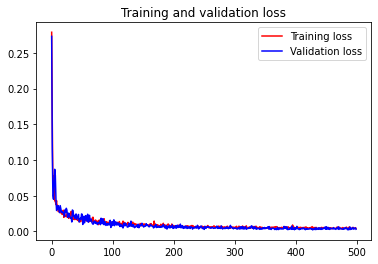

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Based on the plot above, the result of model training is good enough because there is no exploding gradient or vanishing gradient. And the model can be considered as bestfit because the difference between training and validation loss is really small.

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 4ms/step


((139, 1), (90, 1))

<a name="eval"></a>

# Model Evaluation

In [39]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Before doing the model evaluation, we were doing inverse transform to make it go back to the base value (value before)

<a name="mse"></a>

### Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [40]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  170.07511687069947
Train data MSE:  28925.545378582083
Train data MAE:  130.6726759217626
-------------------------------------------------------------------------------------
Test data RMSE:  180.8324546483515
Test data MSE:  32700.3766541481
Test data MAE:  138.90276692708332


<a name="var"></a>

### Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [41]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9359261980944702
Test data explained variance regression score: 0.8526165991086918


<a name="r2"></a>

### R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

In [42]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9341199751437308
Test data R2 score: 0.7908197520135798


From the r2-score shown above, it is seen that the model is good enough with 0.93 train score, and 0.8 test score.

<a name="mpd"></a>

### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [43]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00043069411570095085
Test data MGD:  0.0003879901039434487
----------------------------------------------------------------------
Train data MPD:  3.5169482967723016
Test data MPD:  3.5596107219183373


<a name="cp"></a>

# Comparison of original stock close price and predicted close price

In [44]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (247, 1)
Test predicted data:  (247, 1)


From the comparison between original close price and predicted close price plot above, we can tell that there's no significant difference which shows that the accuracy between original and predicted close price is good enough.

<a name="days"></a>

# Predicting next 30 days

the next step is predicting the close price for the next 30 days using the last 7 days data as the reference pattern.

In [45]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.89312977 0.88549618 0.92366412 0.88549618 0.87022901 0.96946565
 0.85496183 0.81577998]
1 day output [[0.76374197]]
[0.8931297709923665, 0.885496183206107, 0.9236641221374047, 0.885496183206107, 0.8702290076335877, 0.9694656488549618, 0.8549618320610688, 0.815779983997345, 0.7637419700622559]
2 day input [0.88549618 0.92366412 0.88549618 0.87022901 0.96946565 0.85496183
 0.81577998 0.76374197]
2 day output [[0.73375225]]
[0.885496183206107, 0.9236641221374047, 0.885496183206107, 0.8702290076335877, 0.9694656488549618, 0.8549618320610688, 0.815779983997345, 0.7637419700622559, 0.7337522506713867]
3 day input [0.92366412 0.88549618 0.87022901 0.96946565 0.85496183 0.81577998
 0.76374197 0.73375225]
3 day output [[0.7152791]]
[0.9236641221374047, 0.885496183206107, 0.8702290076335877, 0.9694656488549618, 0.8549618320610688, 0.815779983997345, 0.7637419700622559, 0.7337522506713867, 0.7152791023254395]
4 day input [0.88549618 0.87022901 0.96946565 0.85496183 0.81577998 0.763

<a name="pdays"></a>

### Plotting last 7 days of dataset and next predicted 30 days

In [46]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7 8]
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38]


In [51]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 7 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 7 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

The plot above shows the model prediction for the next 30 days, and there is downtrend.

<a name="pwhole"></a>

### Plotting entire Closing Stock Price with next 30 days period of prediction 

and the next is visualizing the overall close stock price with the predicition result.

In [48]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# SAVE MODEL

In [49]:
model.save('model_bni.h5')

In [50]:
import pickle
with open("scaler_bni.pkl", "wb") as f:
    pickle.dump(scaler, f)